In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

In [4]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.affine1 = nn.Linear(4, 128)
#         self.affine2 = nn.Linear(128, 2)

# #         self.saved_log_probs = []
# #         self.rewards = []

#     def forward(self, x):
#         x = F.relu(self.affine1(x))
#         action_scores = self.affine2(x)
#         return F.softmax(action_scores, dim=1)
    
Net = lambda: nn.Sequential(nn.Linear(4,128),nn.ReLU(),nn.Linear(128,2),nn.Softmax(dim=1))


class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99,
                episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): 
#                 episode2thresh=lambda i: 0): # without exploration
                # eploration will start after 150 episodes
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = 0
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train(True)
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.train(False)
        state = torch.from_numpy(obs).float().unsqueeze(0)
        prob = self.model(Variable(state))
        max_prob, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = torch.from_numpy(obs).float().unsqueeze(0)
    probs = model(Variable(state))
    m = Categorical(probs)
    if np.random.random()>thresh:
#         print(probs)
        try:
            action = m.sample()
        except:
            print(probs,m)
            raise
    else:
        action_space = probs.size(1)
        action = Variable(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = Variable(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [5]:
def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)

In [8]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=1e-2,weight_decay=0.001)
trainer = PolicyGradient(model=net)

In [9]:
env = gym.make('CartPole-v1')

for episode in range(10000):
    obs = env.reset()
    total_reward = 0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.select_action(obs)
        obs, reward, done, _ = trainer.take_action(action, env, render=False)
        total_reward+=reward
        if done:
             break
    policy_loss = trainer.get_loss_and_clear()
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>env.spec.reward_threshold:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

0 37.0 0.37000000000000033
1 25.0 0.6163000000000005
2 36.0 0.9701370000000008
3 13.0 1.0904356300000009
4 9.0 1.169531273700001
5 26.0 1.4178359609630011
6 10.0 1.5036576013533711
7 14.0 1.6286210253398374
8 11.0 1.722334815086439
9 9.0 1.7951114669355748
10 11.0 1.887160352266219
11 9.0 1.958288748743557
12 12.0 2.0587058612561213
13 13.0 2.1681188026435603
14 12.0 2.2664376146171246
15 13.0 2.373773238470953
16 10.0 2.4500355060862438
17 12.0 2.545535151025381
18 16.0 2.6800797995151275
19 13.0 2.7832790015199764
20 11.0 2.8654462115047767
21 9.0 2.9267917493897286
22 11.0 3.0075238318958313
23 11.0 3.087448593576873
24 17.0 3.2265741076411043
25 13.0 3.3243083665646935
26 24.0 3.5310652828990468
27 20.0 3.6957546300700566
28 12.0 3.778797083769356
29 15.0 3.8910091129316626
30 15.0 4.002099021802346
31 15.0 4.112078031584323
32 23.0 4.30095725126848
33 32.0 4.577947678755796
34 26.0 4.792168201968238
35 12.0 4.864246519948556
36 23.0 5.045604054749071
37 20.0 5.19514801420158
38 28

In [10]:
torch.save(net.state_dict(), "pg_exploration.pth")

In [11]:
for i in range(20):
    obs = env.reset()
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.greedy_policy(obs)
        obs, reward, done, _ = env.step(action)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s"%total_reward)

Encore: 500.0
Encore: 500.0
Encore: 500.0


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

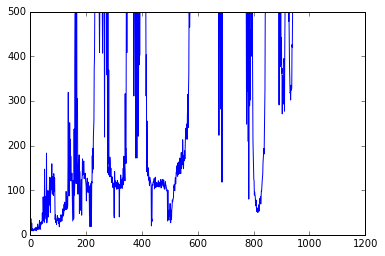

In [13]:
plt.plot(trainer.total_rewards)